Marcella Komunita Pasaribu<br>https://www.kaggle.com/mahirkukreja/delhi-weather-data

In [307]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [317]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [318]:
df = pd.read_csv('/content/drive/My Drive/testset.csv')
df

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100985,20170424-06:00,Haze,17.0,0,0,NaN,25.0,NaN,1005.0,0,0,34.0,0,0,4.0,320.0,NW,NaN,NaN,11.1
100986,20170424-09:00,Haze,14.0,0,0,NaN,16.0,NaN,1003.0,0,0,38.0,0,0,4.0,320.0,NW,NaN,NaN,22.2
100987,20170424-12:00,Haze,12.0,0,0,NaN,14.0,NaN,1002.0,0,0,36.0,0,0,4.0,270.0,West,NaN,NaN,18.5
100988,20170424-15:00,Haze,15.0,0,0,NaN,27.0,NaN,1004.0,0,0,32.0,0,0,2.0,320.0,NW,NaN,NaN,3.7


In [319]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df.rename(columns={'datetime_utc':'date',' _tempm':'meantemp'}, inplace=True)
df

,date,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,meantemp,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100985,2017-04-24 06:00:00,Haze,17.0,0,0,NaN,25.0,NaN,1005.0,0,0,34.0,0,0,4.0,320.0,NW,NaN,NaN,11.1
100986,2017-04-24 09:00:00,Haze,14.0,0,0,NaN,16.0,NaN,1003.0,0,0,38.0,0,0,4.0,320.0,NW,NaN,NaN,22.2
100987,2017-04-24 12:00:00,Haze,12.0,0,0,NaN,14.0,NaN,1002.0,0,0,36.0,0,0,4.0,270.0,West,NaN,NaN,18.5
100988,2017-04-24 15:00:00,Haze,15.0,0,0,NaN,27.0,NaN,1004.0,0,0,32.0,0,0,2.0,320.0,NW,NaN,NaN,3.7


In [320]:
df.isnull().sum()

date                 0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
meantemp           673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [321]:
df['meantemp'].fillna(df['meantemp'].mean(), inplace=True)
df = df[['date','meantemp' ]]
df.isnull().sum()

date        0
meantemp    0
dtype: int64

In [322]:
df.set_index('date', inplace= True)
df = df.resample('d').mean()
df.isnull().sum()

meantemp    141
dtype: int64

In [323]:
df['meantemp'].fillna(df['meantemp'].mean(), inplace=True)
df.isnull().sum()

meantemp    0
dtype: int64

In [324]:
df

,meantemp
date,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.900000


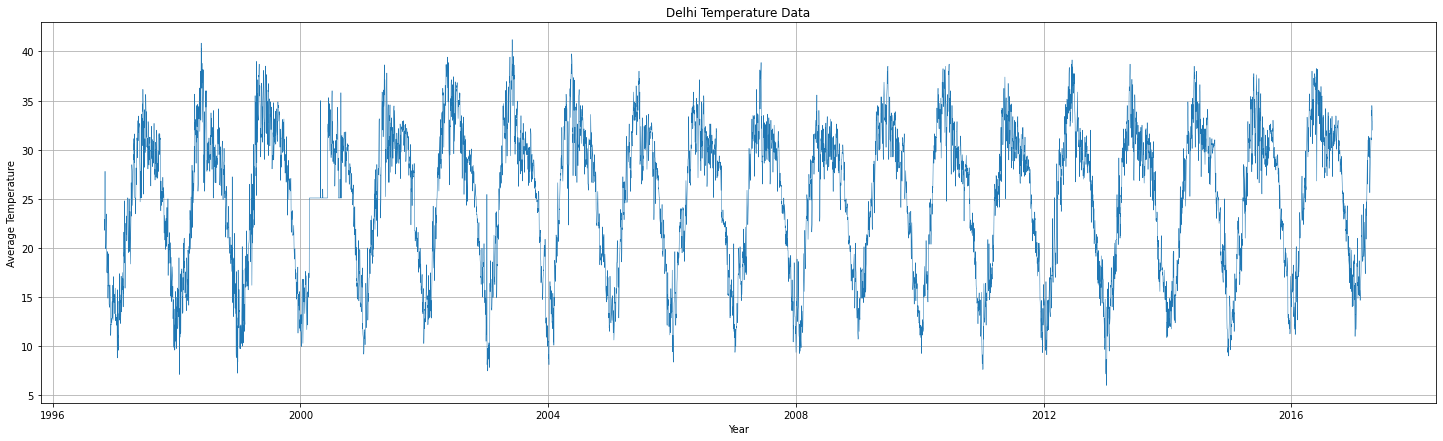

In [325]:
plt.figure(figsize=(25, 7))
plt.plot(df, linewidth=.5)
plt.grid()
plt.title("Delhi Temperature Data")
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.show()

In [326]:
df.reset_index(inplace=True)
dates = df['date'].values
temp = df['meantemp'].values

In [327]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [328]:
temp_train, temp_test, y_train, y_test= train_test_split(temp, dates, test_size = 0.2, random_state = 0 , shuffle=False)

train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [329]:
Mae = (df['meantemp'].max() - df['meantemp'].min()) * 10/100
print(Mae)

3.5210526315789474


In [330]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < Mae and logs.get('val_mae') < Mae):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [331]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = test_set, callbacks=[callbacks])

Epoch 1/100
60/60 [==============================] - 10s 114ms/step - loss: 24.0366 - mae: 24.5366 - val_loss: 23.9736 - val_mae: 24.4736
Epoch 2/100
60/60 [==============================] - 6s 103ms/step - loss: 22.4303 - mae: 22.9303 - val_loss: 21.6932 - val_mae: 22.1932
Epoch 3/100
60/60 [==============================] - 6s 103ms/step - loss: 19.1752 - mae: 19.6751 - val_loss: 16.7517 - val_mae: 17.2517
Epoch 4/100
60/60 [==============================] - 6s 102ms/step - loss: 11.1977 - mae: 11.6902 - val_loss: 6.4148 - val_mae: 6.9051
Epoch 5/100
60/60 [==============================] - 6s 101ms/step - loss: 5.3810 - mae: 5.8674 - val_loss: 5.1842 - val_mae: 5.6745
Epoch 6/100
60/60 [==============================] - 6s 102ms/step - loss: 4.1290 - mae: 4.6067 - val_loss: 2.8605 - val_mae: 3.3294
Epoch 7/100
60/60 [==============================] - 6s 101ms/step - loss: 2.3339 - mae: 2.7944 - val_loss: 1.6835 - val_mae: 2.1308

MAE dari model < 10% skala data


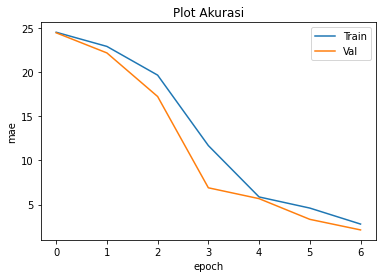

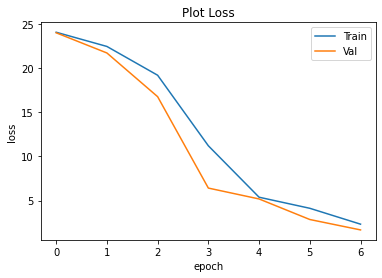

In [332]:
# plot akurasi
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Plot Akurasi')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()